# Noise Modeling
This notebook is for analyzing the properties of the background noise that would be generated by an ensemble of neurons outside of the region being modeled, so that the correct noise profile can be used elsewhere. So far, it looks like $1/f$ noise is the right model, but with a finite correlation time.

In [1]:
%matplotlib nbagg
import functools
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from braingeneers import drylab
import colorednoise as cn
    
def white_noise(*args, size):
    return np.random.normal(size=size)

def brown_noise(*args, size):
    return np.cumsum(white_noise(size=size), axis=-1)

def pink_noise(*args, size, fmin=0):
    return cn.powerlaw_psd_gaussian(exponent=1, size=size, fmin=fmin)


In [2]:
# Number of neurons, followed by the number which are excitatory.
N = 1000
Ne = 800

# How much stronger inhibitory connections are than excitatory ones.
inhibition_factor = 1.5

# Used for constructing nonhomogeneous neural populations,
# interpolated between two types based on the value of
# r ∈ [0,1]. Excitatory neurons go from Regular Spiking
# to Chattering, while inhibitory neurons go from
# Low-Threshold Spiking to Late Spiking models over the
# same range. Adapted from Izhikevich's writings.
r = np.random.rand(N) # unitless
l = np.ones(N) # unitless

# a : 1/ms recovery time constant of membrane leak currents
a = np.hstack((0.03*l[:Ne], 0.03 + 0.14*r[Ne:]))
# b : nS recovery conductivity
b = np.hstack((-2 + 3*r[:Ne]**2, 8 - 3*r[Ne:]))
# c : mV voltage of the downstroke
c = np.hstack((-50 + 10*r[:Ne]**2, -53 + 8*r[Ne:]))
# d : pA instantaneous increase in leakage during downstroke
d = np.hstack((100 + 50*r[:Ne]**2, 20 + 80*r[Ne:]))
# C : pF membrane capacitance
C = np.hstack((100 - 50*r[:Ne]**2, 100 - 80*r[Ne:]))
# k : nS/mV Na+ voltage-gated channel conductivity parameter
k = np.hstack((0.7 + 0.8*r[:Ne]**2, 1 - 0.7*r[Ne:]))
# mV : resting membrane voltage
Vr = np.hstack((-60*l[:Ne], -56 - 10*r[Ne:]))
# mV : threshold voltage at u=0
Vt = np.hstack((-40*l[:Ne], -42 + 2*r[Ne:]))

# tau : ms time constant of synaptic current
tau = 3

# Sij : pA total EPSC generated in neuron i when neuron j fires.
mu, sigma = -0.702, 0.9355  # taken from Song (2005).
S = np.random.lognormal(mean=mu, sigma=sigma, size=(N,N))
S *= np.median(C / tau)
S[:,Ne:] *= -inhibition_factor

excitatory = np.arange(N) < Ne
inhibitory = np.arange(N) >= Ne

# XY : um planar positions of the cells
XY = np.random.rand(2,N) * 70

## Run a simulation.

In [3]:
n_pink = drylab.Organoid(XY=XY, S=S, tau=tau, 
                         a=a, b=b, c=c, d=d, 
                         k=k, C=C, Vr=Vr, Vt=Vt)
n_white = drylab.Organoid(XY=XY, S=S, tau=tau,
                          a=a, b=b, c=c, d=d, 
                          k=k, C=C, Vr=Vr, Vt=Vt)

pinks = pink_noise(size=(N,2001))
whites = white_noise(size=(N,2001))

Awhite, Apink = 150, 100

currentsw, currentsp = np.zeros_like(whites), np.zeros_like(pinks)
firingsw, firingsp = [], []
for t in range(2001):
    _, firedw = n_white.step(whites[:,t] * Awhite)
    _, firedp = n_pink.step(pinks[:,t] * Apink)
    currentsw[:,t] = n_white.Isyn
    currentsp[:,t] = n_pink.Isyn
    for i in range(N):
        if firedw[i]:
            firingsw.append((t,i))
        if firedp[i]:
            firingsp.append((t,i))

firingsw = np.array(firingsw)
firingwe = excitatory[firingsw[:,1]]
firingwi = inhibitory[firingsw[:,1]]

firingsp = np.array(firingsp)
firingpe = excitatory[firingsp[:,1]]
firingpi = inhibitory[firingsp[:,1]]

## The activity difference between pink and white noise...

<IPython.core.display.Javascript object>


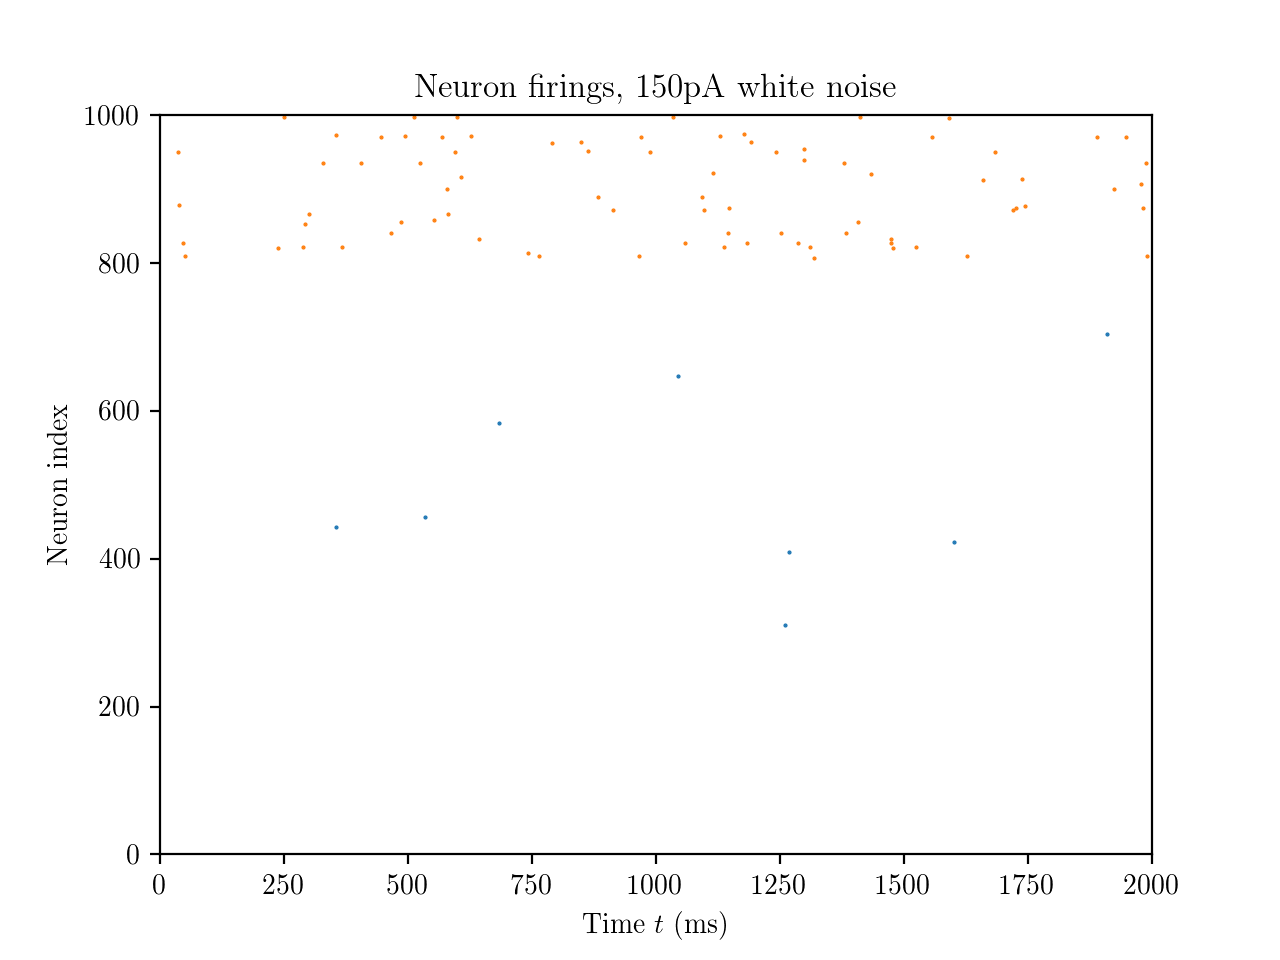

In [4]:
plt.figure()
plt.plot(firingsw[firingwe,0], firingsw[firingwe,1], 
         '.', markersize=1, label='excitatory')
plt.plot(firingsw[firingwi,0], firingsw[firingwi,1], 
         '.', markersize=1, label='inhibitory')
plt.title(f'Neuron firings, {Awhite}pA white noise')
plt.xlabel('Time $t$ (ms)')
plt.ylabel('Neuron index')
plt.xlim([0,2000])
plt.ylim([0,1000]) and None

<IPython.core.display.Javascript object>


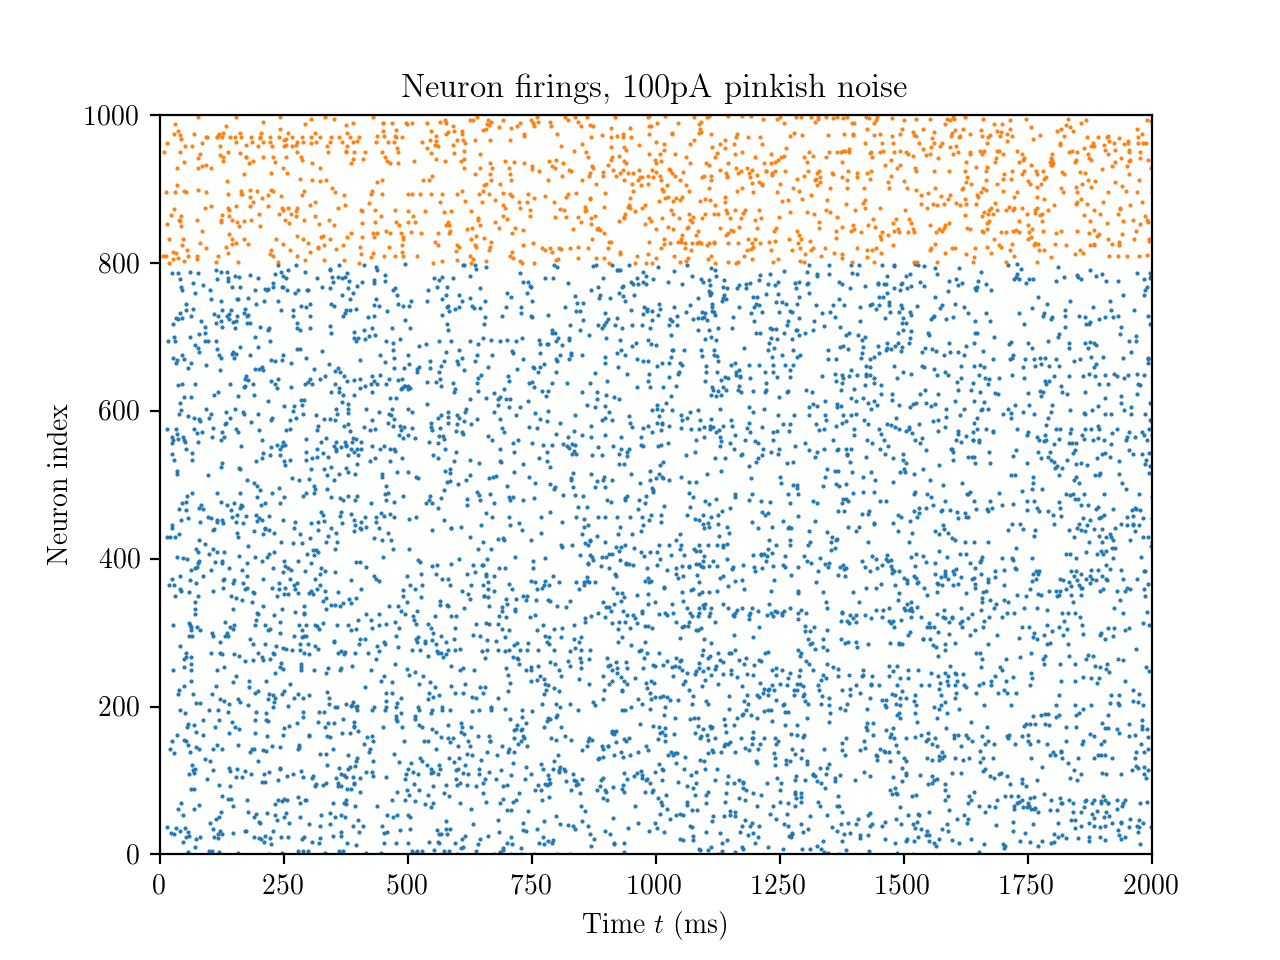

In [5]:
plt.figure()
plt.plot(firingsp[firingpe,0], firingsp[firingpe,1], 
         '.', markersize=1, label='excitatory')
plt.plot(firingsp[firingpi,0], firingsp[firingpi,1], 
         '.', markersize=1, label='inhibitory')
plt.title(f'Neuron firings, {Apink}pA pinkish noise')
plt.xlabel('Time $t$ (ms)')
plt.ylabel('Neuron index')
plt.xlim([0,2000])
plt.ylim([0,1000]) and None

## What neural activity actually looks like.

In [6]:
freq, pow = signal.welch(currentsp)

# See how close this is to 1/f noise with a cutoff by fitting a model.
def model(params):
    a0, fmin = params
    return a0 * np.minimum(fmin/freq, 1)
    
def error(params):
    powhat = model(params)
    @functools.partial(np.vectorize, signature='(n)->()')
    def one_error(onepow):
        return np.sum((onepow - powhat)**2)
    return one_error(pow).sum()

from scipy import optimize as spo
params = spo.fmin(error, (1000,0.1))
powhat = model(params)

print(f'Neural noise PSD seems to have a knee at correlation time {1/params[1]:0.1f}ms.')

/Applications/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


Optimization terminated successfully.
         Current function value: 5293731014.716053
         Iterations: 59
         Function evaluations: 116
Neural noise PSD seems to have a knee at correlation time 6.1ms.


<IPython.core.display.Javascript object>


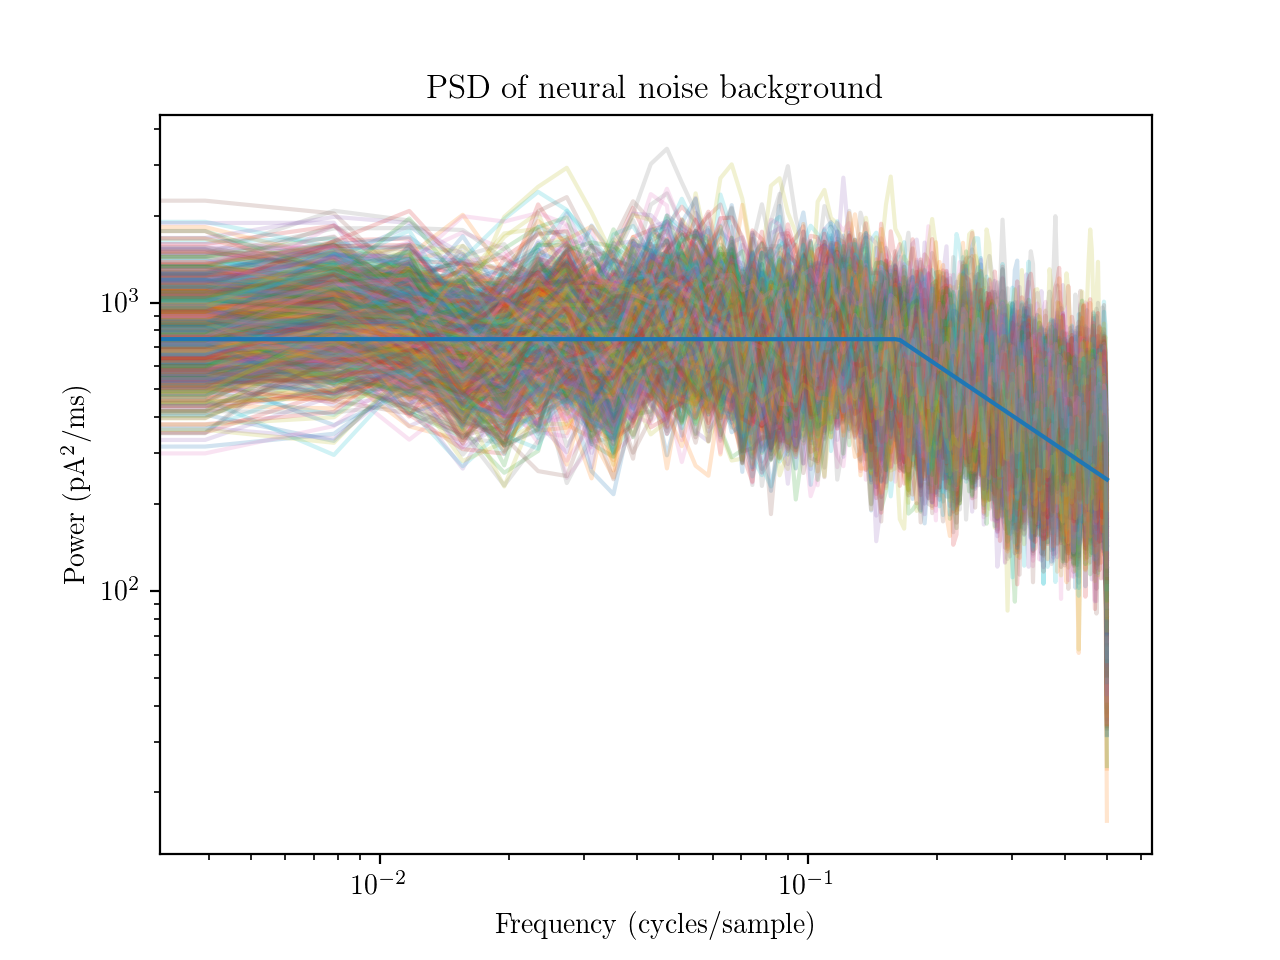

In [7]:
plt.figure()
plt.loglog(freq, pow.T, alpha=0.2)
plt.loglog(freq, powhat)
plt.title('PSD of neural noise background')
plt.xlabel('Frequency (cycles/sample)')
plt.ylabel('Power (pA$^2$/ms)') and None

## Alternate characterization of correlation time.
The autocorrelation function of a stationary process (which $1/f^\beta$ noise is, at least for $\beta\in[0,1]$) is a function of delay time given for a zero-mean process by

$$R(\Delta t) = \mathbb{E}[x(t+\Delta t)\ x(t)]$$

We calculate it by convolving the signal with its reversal, averaging over many instantiations of the process, here 1000. (First, we have to make the process zero-mean by estimating the mean from the same instantiations and subtracting it.)

With this function, the correlation time is defined by the sum of autocorrelation over time positive time, normalized by the variance (correlation of $x(t)$ with itself). That value is calculated below to be very small, unfortunately: about 3ms.

In [14]:
@functools.partial(np.vectorize, signature='(n)->(n)')
def autocorr(x):
    N = len(x)
    x = np.asarray(x)
    # x = (x - x.mean()) / x.std()
    # Correlation is backwards convolution.
    # This one is symmetric with size 2N - 1, 
    # so discard the first half to get just N.
    return np.convolve(x, x[::-1])[N-1:] / N

pink_acm = autocorr(pinks - pinks.mean()).mean(axis=0)
ac = autocorr((currentsp - currentsp.mean()) / currentsp.std())
acm = ac.mean(axis=0)

print(f'Correlation time = {acm.sum() / acm[0]:0.1f}ms.')

Correlation time = 4.7ms.


<IPython.core.display.Javascript object>


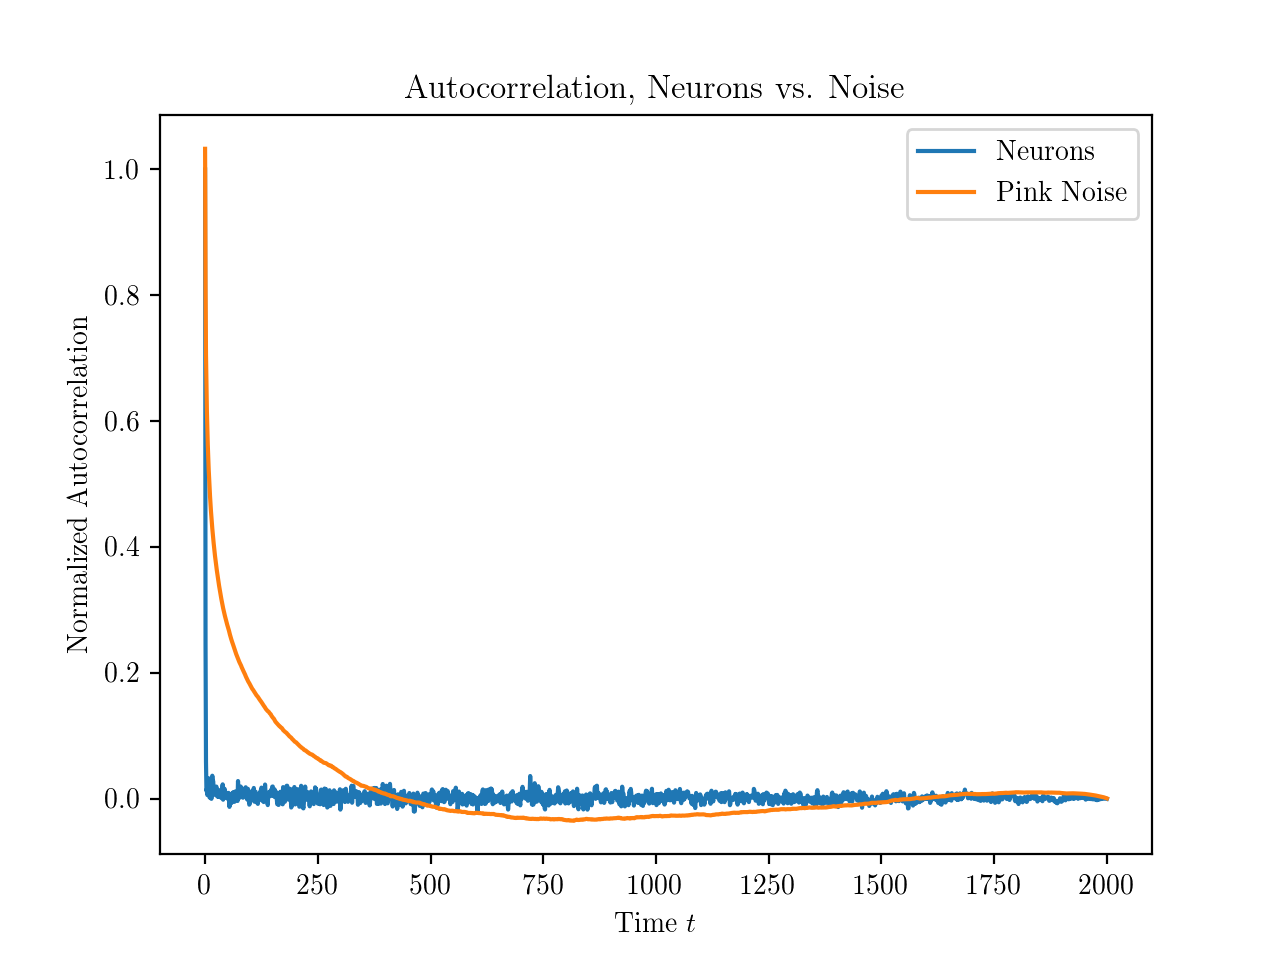

Text(0, 0.5, 'Normalized Autocorrelation')

In [17]:
plt.figure()
plt.plot(acm, label='Neurons')
plt.plot(pink_acm, label='Pink Noise')
plt.title('Autocorrelation, Neurons vs. Noise')
plt.legend()
plt.xlabel('Time $t$')
plt.ylabel('Normalized Autocorrelation')